# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.
##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.
##### (6) 2007년과 2008년 데이터를 예측하여라

In [ ]:
#collapse
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2)
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [22]:
#collapse
z <- as.numeric(mcopper)

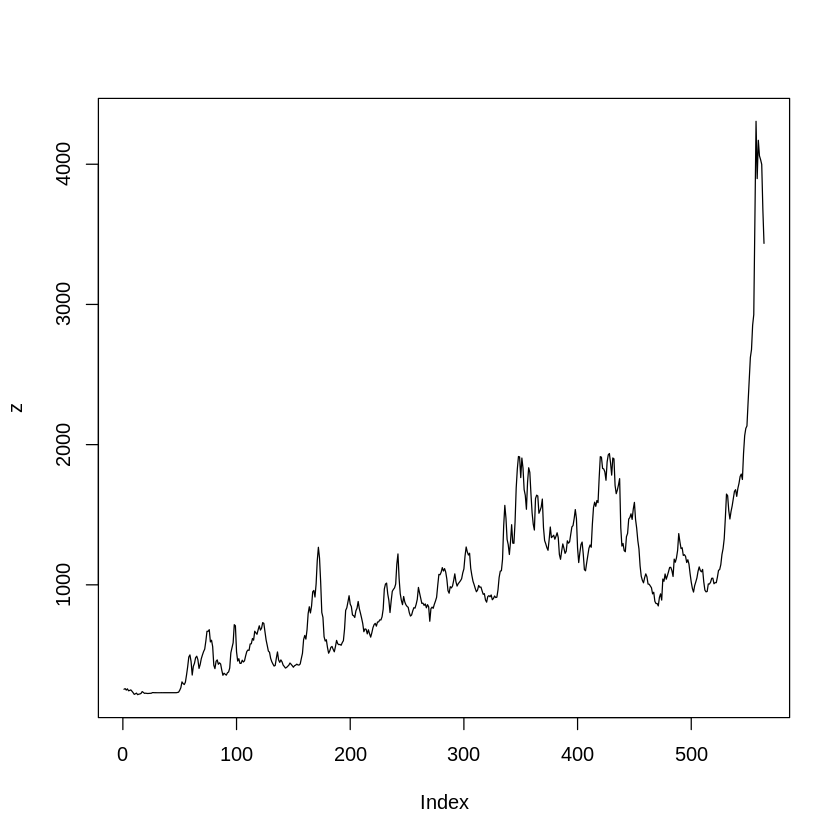

In [23]:
#collapse
plot(z, type='l')

- 등분산을 이루지 않고 있는 모습을 보인다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

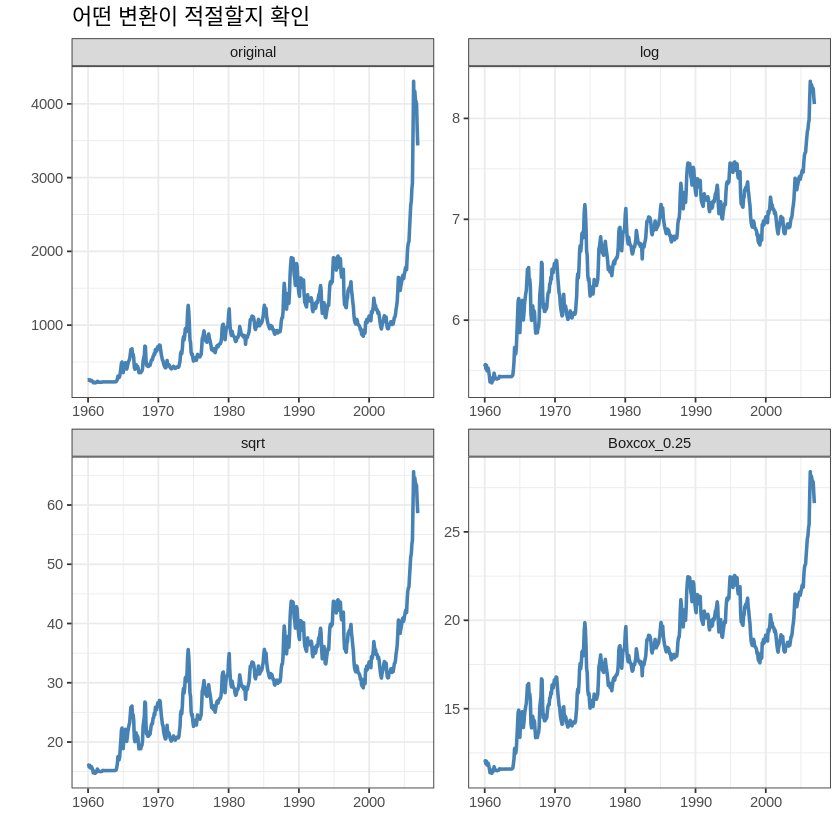

In [24]:
#collapse
tmp.dat <- data.table(
  t=seq.Date(as.Date("1960-01-01"), 
             by='month', 
             length.out=564),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.25 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("어떤 변환이 적절할지 확인")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

In [25]:
tmp.dat[, lnz:= log(z)]

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 적용했다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [26]:
auto.arima(tmp.dat$lnz)
auto.arima(tmp.dat$lnz, trace=T, ic='aic')

Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -1555.199
 ARIMA(0,1,0) with drift         : -1485.363
 ARIMA(1,1,0) with drift         : -1543.596
 ARIMA(0,1,1) with drift         : -1556.04
 ARIMA(0,1,0)                    : -1484.453
 ARIMA(1,1,1) with drift         : -1553.325
 ARIMA(0,1,2) with drift         : -1554.063
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,1)                    : -1556.275
 ARIMA(1,1,1)                    : -1553.645
 ARIMA(0,1,2)                    : -1554.28
 ARIMA(1,1,0)                    : -1544.171
 ARIMA(1,1,2)                    : -1555.619

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,1)                    : -1561.685

 Best model: ARIMA(0,1,1)                    



Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- ARIMA(0,1,1) 모형, 즉 한 번 차분한 MA(1) 모형이 제일 적합하다는 결론이 나왔다.

In [39]:
fit = arima(tmp.dat$lnz, order = c(0,1,1), , seasonal = list(order = c(0,0,0), period = 0))
fit


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

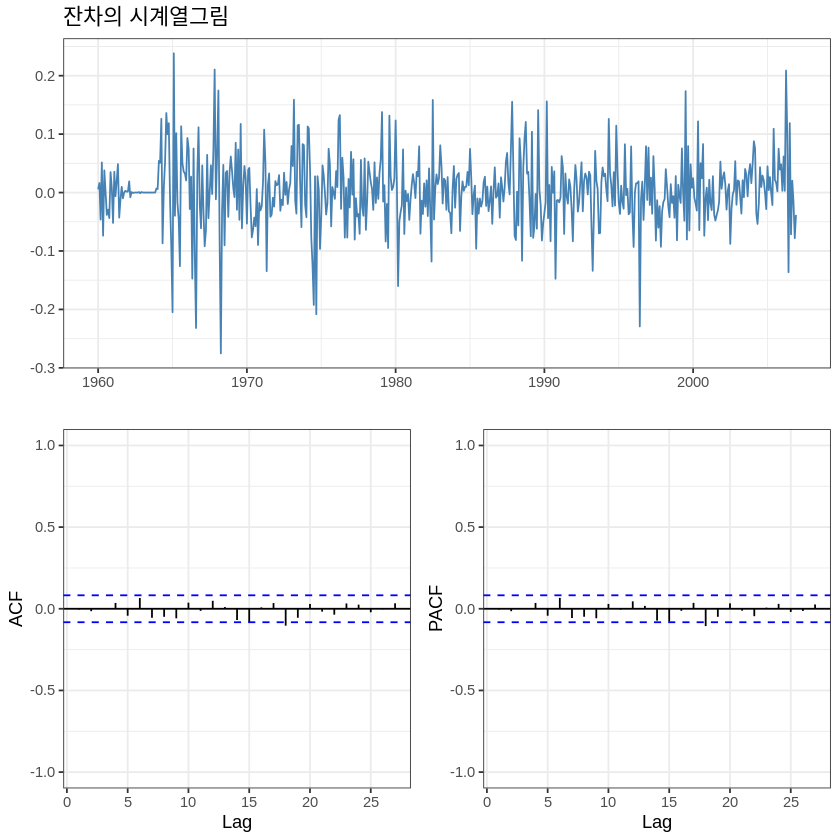

In [40]:
#collapse
tmp.dat[, res := as.numeric(resid(fit))]

p3 <- ggplot(tmp.dat, aes(t, res)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+
  theme_bw()

p1 <- ggAcf(tmp.dat$res) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(tmp.dat$res) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

,lags,statistic,df,p-value
,6,4.389073,5,0.49486084
,12,11.774747,11,0.38081082
,18,25.513977,17,0.08378234
,24,29.716259,23,0.15772145



	Shapiro-Wilk normality test

data:  tmp.dat$res
W = 0.96372, p-value = 1.406e-10


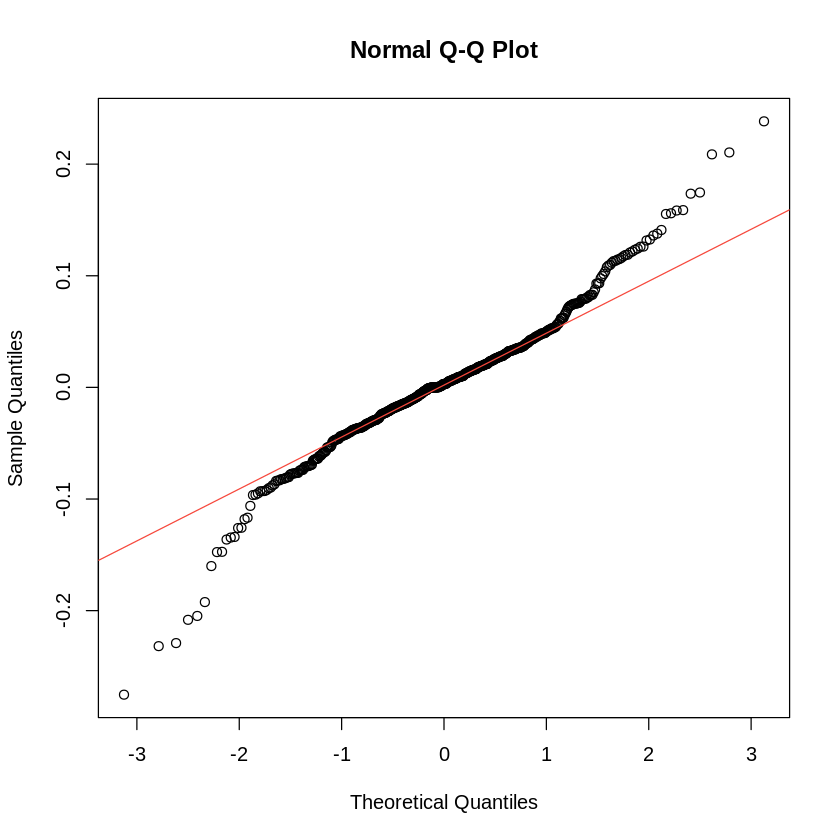

In [41]:
#collapse
LjungBox(fit, lags=seq(6,24,6))
shapiro.test(tmp.dat$res) 
qqnorm(tmp.dat$res)
qqline(tmp.dat$res, col = 2)

- 해당 모형에 적합한 후 잔차 그림을 그려보니 ACF,PACF에서 유의한 값을 찾을 수 없었고, 잔차그림도 잘 분산되어 있는 것 같다.
- 잔차의 포트맨토검정결과 모두 귀무가설을 기각하지 못해 모형 적합이 잘되었나 싶었지만, shapiro.test 결과 정규성가정을 만족하지 못했다.

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

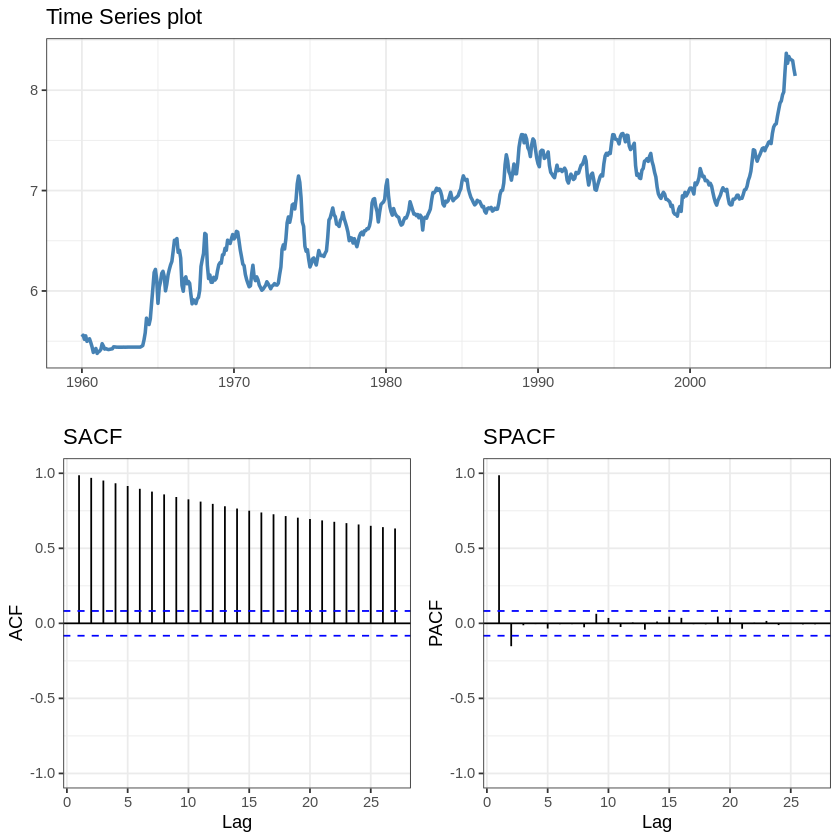

In [30]:
#collapse
p1 <- ggplot(tmp.dat, aes(t, lnz)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot")+
  theme_bw()
p2 <- ggAcf(tmp.dat$lnz) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat$lnz) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- log 변환 후 plot을 그려보니 양의 상관관계가 있어보이긴 하나, 이분산성이 아직 존재하는 것처럼 보인다.
- ACF가 지수적으로 천천히 감소하는 모습을 보여 차분이 필요할 것 같다.
- PACF가 2까지 유의한 것을 보니 MA(2) 모형을 선택할 수도 있겠다.

In [45]:
tmp.dat[, diff_z := c(0, diff(lnz))]

- 차분하였다.

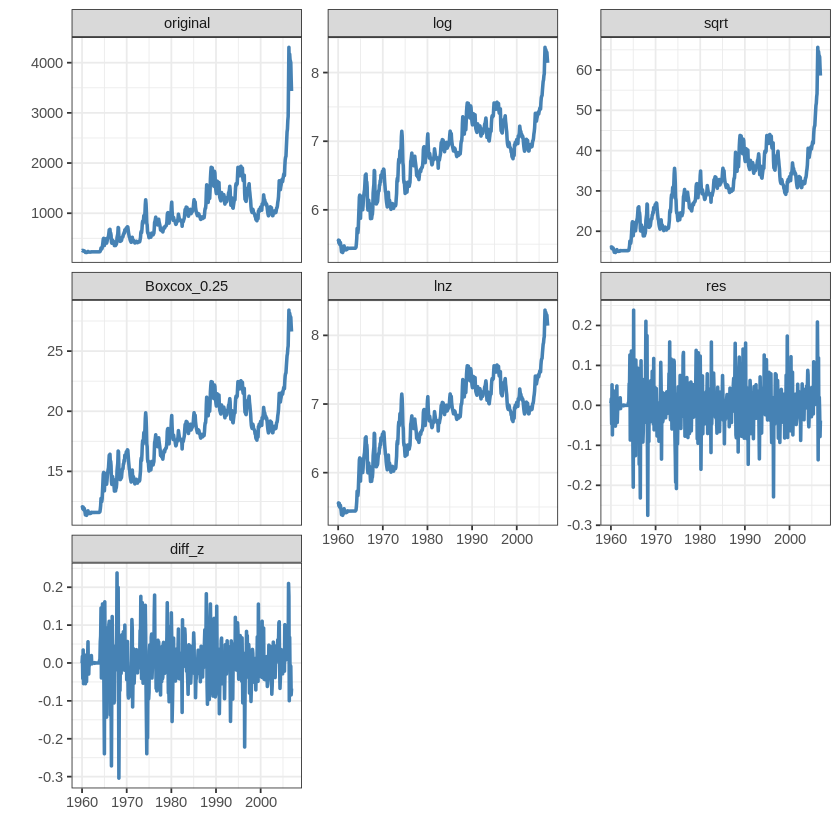

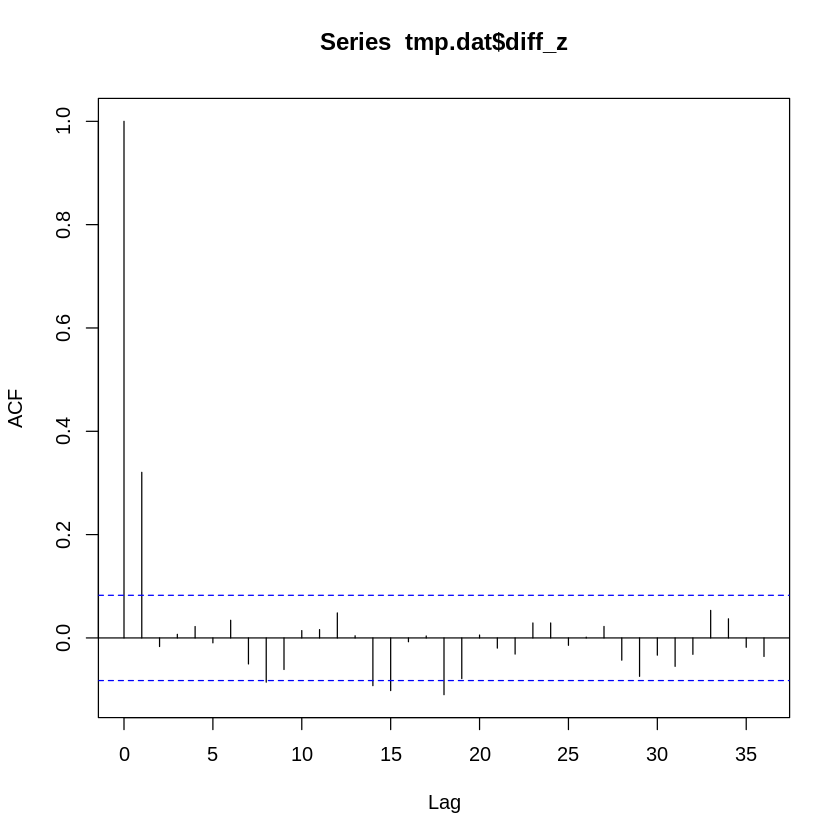

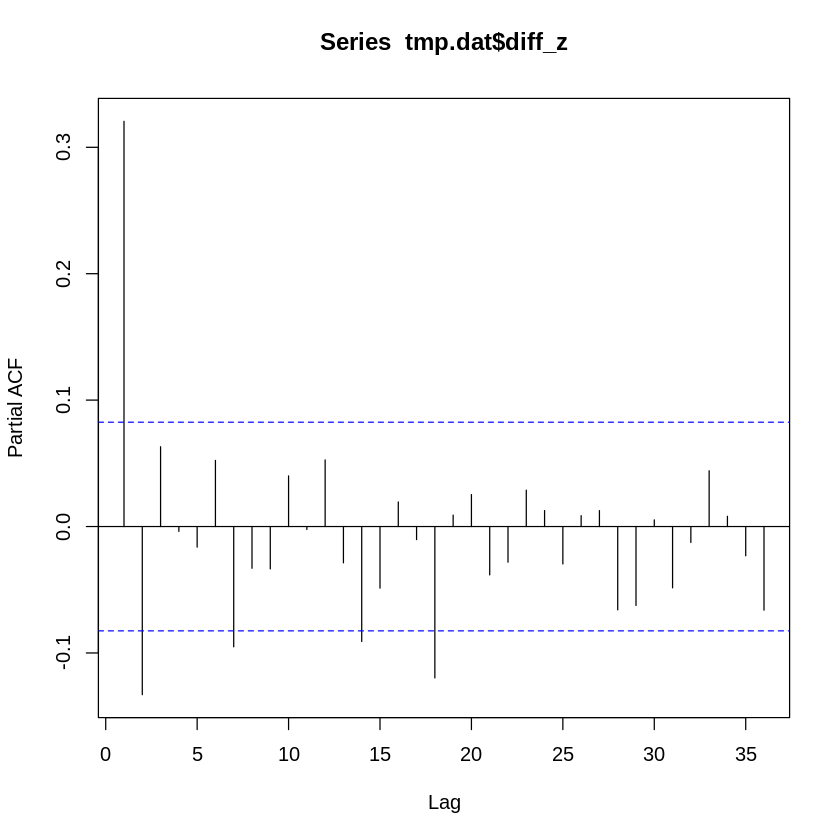

In [46]:
melt_dt <- melt(tmp.dat, id=1)

ggplot(melt_dt, aes(t, value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  # ggtitle("Time Series plot : diff(Random Walk)")+
  # scale_x_continuous(breaks = seq(0,30, by = 6))+
  # geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()+
  facet_wrap(~variable, scales = 'free_y')

acf(tmp.dat$diff_z, lag.max = 36)
# 12차수에서만 유의하지 않음, 24,36에서도 유의
pacf(tmp.dat$diff_z, lag.max = 36)
# 12차수만 유의하고 뒤는 안 그래.

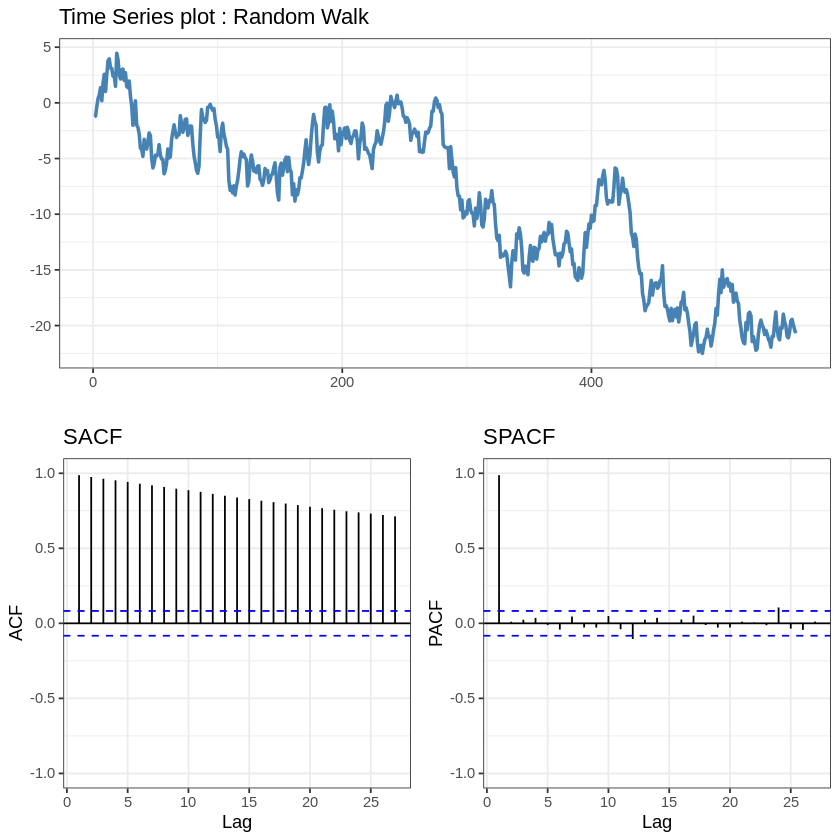

In [44]:
#collapse
e <- rnorm(564)

tmp.dat1 <- data.table(t=1:564, z=cumsum(e))
tmp.dat1[, dz := c(0, diff(z))]


p1 <- ggplot(tmp.dat1, aes(t, z)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : Random Walk")+
  theme_bw()
p2 <- ggAcf(tmp.dat1$z) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat1$z) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- 확률보행과정 정상화 후 그림을 그려보았다.
- SACF 가 천천히 지수적으로 감소하고 있는 것처럼 보인다. 따라서 차분이 필요하겠다.
- ACF 는 lag 1에서만 유의하게 나왔다.

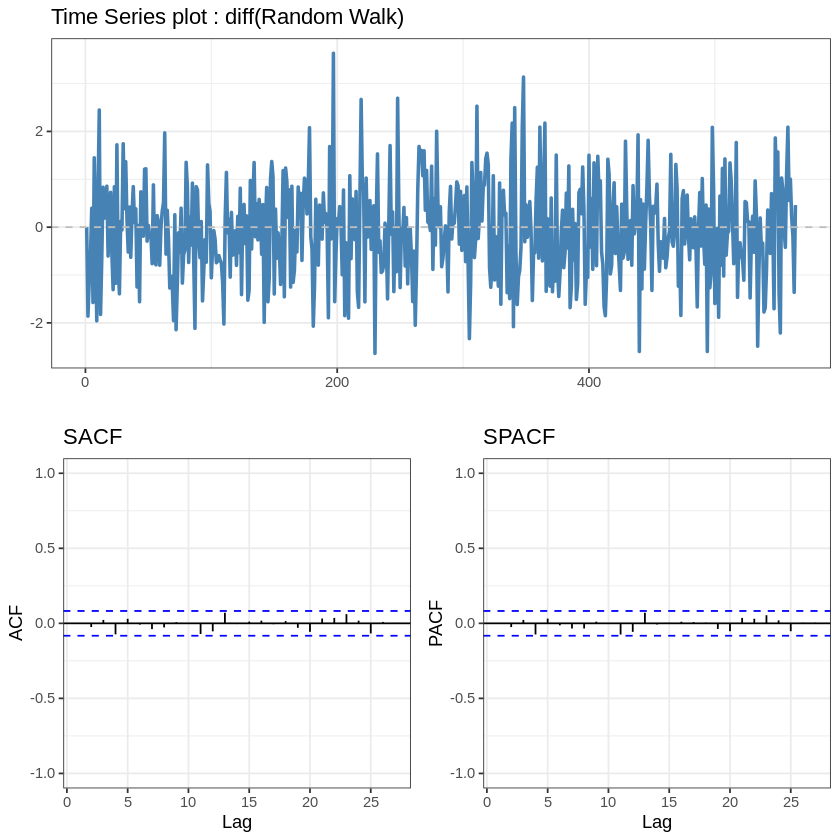

In [37]:
p1 <- ggplot(tmp.dat1, aes(t, dz)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("Time Series plot : diff(Random Walk)")+
  geom_hline(yintercept = 0, lty=2, col='grey')+
  theme_bw()

p2 <- ggAcf(tmp.dat1$dz) + 
  theme_bw() + ylim(-1,1) +
  ggtitle("SACF")

p3 <- ggPacf(tmp.dat1$dz) + 
  theme_bw() +ylim(-1,1) +
  ggtitle("SPACF")
grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

- 차분한 확률보행과정의 plot을 그려보았다.
- ACF, PACF 모두 유의하지 않은, 백색소움 과정의 모습처럼 나온 것을 볼 수 있었다.